# Generate Gaussian Samples

## Positive Samples

We are going to demostrate the RBF network for 3 dimensional Guassian distribution.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option("display.max_rows",15)
import matplotlib.pyplot as plt
import math
import sys
from tensorflow.python import debug as tf_debug

%matplotlib inline

In [2]:
class hp:
    n = 1000
    f = 2

train_mean = np.full(shape=(hp.f), fill_value = 0.5)
train_var = [[1,0.6],[0.2,3]]
train_var = np.matmul(train_var, np.transpose(train_var)) # To make sure that the covariance matrix in positive semi-definate

test_mean_1 = np.full(shape=(hp.f), fill_value = 1.2)
test_var_1 = [[1,1.6],[0.6,2]]
test_var_1 = np.matmul(test_var_1, np.transpose(test_var_1))

test_mean_2 = np.full(shape=(hp.f), fill_value = 10)
test_var_2 = [[1,0.6],[2.2,3]]
test_var_2 = np.matmul(test_var_2, np.transpose(test_var_2))

test_mean_3 = np.full(shape=(hp.f), fill_value = 20)
test_var_3 = [[1,0.6],[0.2,3]]
test_var_3 = np.matmul(test_var_3, np.transpose(test_var_3))


class Dataset:
    train_positive = pd.DataFrame(
        np.random.multivariate_normal(mean=train_mean, cov=train_var, size = hp.n))
    
    test_negative_1 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_1, cov=test_var_1, size = hp.n))
    
    test_negative_2 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_2, cov=test_var_2, size = hp.n))
    
    test_negative_3 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_3, cov=test_var_3, size = hp.n))
    

## Negative Samples

In [3]:
Dataset.train_positive

,0,1
0,1.381668,1.533562
1,-0.202539,1.170842
2,1.299891,4.034340
3,-0.463792,-1.441148
4,0.245474,4.381653
5,-0.976683,-4.560473
6,0.800758,-0.301503
...,...,...
993,2.027203,6.038950
994,-0.873727,4.039998


Training Data (Normal)

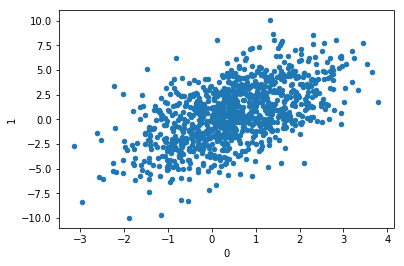

In [4]:
Dataset.train_positive.plot.scatter(x=0, y=1)

Testing Data 1 (Anamoly)

Similar Mean Different Variation

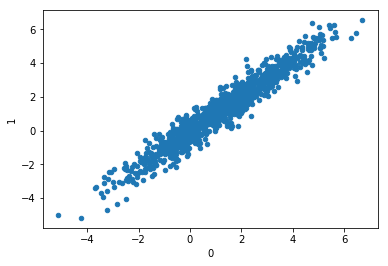

In [5]:
Dataset.test_negative_1.plot.scatter(x=0, y=1)

Testing Data 2 (Anamoly)

Different Mean Different Variation

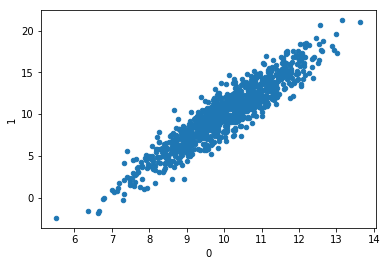

In [6]:
Dataset.test_negative_2.plot.scatter(x=0, y=1)

Testing Data 3 (Anamoly)

Different Mean similar Variation 

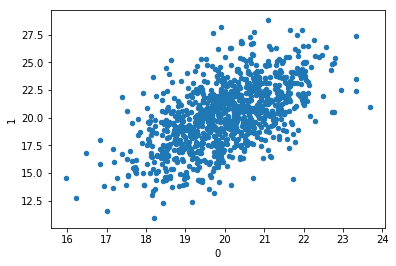

In [7]:
Dataset.test_negative_3.plot.scatter(x=0, y=1)

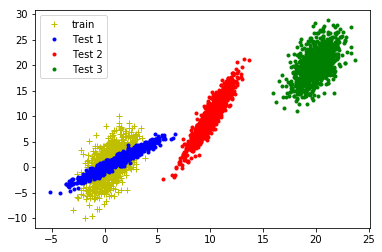

In [8]:
plt.plot(Dataset.train_positive[0], Dataset.train_positive[1], 'y+', label='train')

plt.plot(Dataset.test_negative_1[0], Dataset.test_negative_1[1], 'b.', label='Test 1')
plt.plot(Dataset.test_negative_2[0], Dataset.test_negative_2[1], 'r.', label='Test 2')
plt.plot(Dataset.test_negative_3[0], Dataset.test_negative_3[1], 'g.', label='Test 3')
plt.legend()

In [9]:


class network:
    
    params = {}
    
    def __init__(self):
        with tf.name_scope('Input'):
            self.X = tf.placeholder(tf.float32, [hp.n, hp.f],name='Variable_X') #hp.n, hp.f
        
    def get_cost(self, U, Z): #U, Q, Q_, Z
        
        #inverse_regularizer = tf.pow((tf.matmul(Q, Q_) - tf.eye(hp.f)), 2)
        cost = - (-U - tf.log(Z)) #+ tf.reduce_sum(inverse_regularizer)) # get -ve log likelihood
        
        #self.params.update({'U_':tf.reduce_mean(U)}) #, 'ir': tf.reduce_sum(inverse_regularizer)
        return tf.reduce_mean(cost)
    
    def get_optimizer(self):
        
        with tf.name_scope('Weights'):
            n = hp.n
            f = hp.f

            X = self.X

            P = tf.Variable(tf.truncated_normal([f]))
            Q_ = tf.Variable(tf.truncated_normal([f])) # [f,f]
            global_step = tf.Variable(0, trainable=False)
            #Q_ = tf.Variable(tf.truncated_normal([f,f]))

        with tf.name_scope('RBF'):
            Q = tf.diag(tf.square(Q_)) + tf.eye(f) #tf.matmul(Q_, tf.transpose(Q_)) 

            X = tf.layers.dense(X, f)
            X = tf.layers.dense(X, f)

            M = P - tf.matmul(X, Q)
            print('M', M.get_shape())

            R = tf.matmul(M, Q)
            print('R', R.get_shape())

            V = tf.matmul(R, tf.transpose(M))
            print('V', V.get_shape())

            U = tf.reduce_sum(V, axis = 1, keepdims = True)
            print('U', U.get_shape())

            Q_det = tf.matrix_determinant(Q)
            print('Q_det', Q_det.get_shape())

            Z = tf.pow(tf.multiply(tf.pow(2*math.pi,f), Q_det), 1/2)
            print('Z', Z.get_shape())
        
        with tf.name_scope('Likelihood'):
            Y_ = tf.divide(tf.exp(-U/2), Z)
            print("Y_", Y_.get_shape())
            
        with tf.name_scope('LossAndOptim'):
            loss = self.get_cost(U, Z) # 1- Y_[0]
            tf.summary.scalar('loss', loss)

            starter_learning_rate = 0.01
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               100, 0.6, staircase=True)
            train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
            tf.summary.scalar("learning_rate",learning_rate)
            
        merged = tf.summary.merge_all()
        
        self.params.update({'U': U, 'P':P, 'Q':Q, 'Z':Z, 'Q_det':Q_det, 'Y_':Y_}) #  

        return merged, train, loss, Y_, self.params


In [10]:
epochs = 1000
loss_arr = []
Dataset.Y_ = []

net = network()
output_tensors = net.get_optimizer()

# tf_debug.TensorBoardDebugWrapperSession(tf.Session(), 'localhost:6064')

with tf.Session() as sess:

    train_writer = tf.summary.FileWriter('logdir/rbf_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        X = np.reshape(Dataset.train_positive.values, (hp.n, -1))
        
        #for i in range(X.shape[0]):
        #x = X#[i,:].reshape((1,-1))
        
        merged, train, loss, Y_, params = sess.run(output_tensors, feed_dict={net.X:X}) 
        
        train_writer.add_summary(merged, epoch)
        loss_arr.append(loss)

        #print("epoch", epoch, "loss", loss)#, 'U', params['U'], 'Z', params['Z']) #, 'IR', params['ir'], 'Z', params['Z'], 'U', params['U']

        Dataset.Y_.append(Y_)
        
    print('P (Mean)', params['P'], 'Q (Covariance)', params['Q'])     

M (1000, 2)
R (1000, 2)
V (1000, 1000)
U (1000, 1)
Q_det ()
Z ()
Y_ (1000, 1)
P (Mean) [-0.2709572  -0.33089048] Q (Covariance) [[1.8121207 0.       ]
 [0.        1.1258575]]


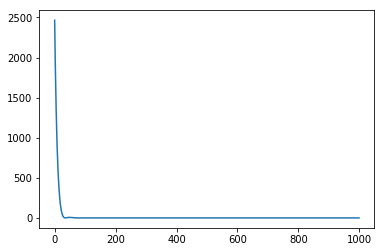

In [11]:
plt.plot(loss_arr)

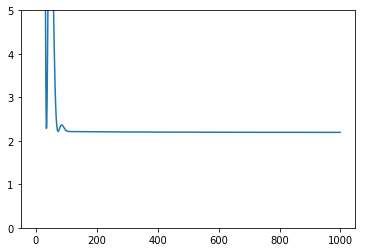

In [12]:
plt.ylim(0, 5)
plt.plot(loss_arr)

(array([  5.,  13.,  72., 156., 255., 243., 172.,  63.,  17.,   4.]),
 array([0.1029198 , 0.10462626, 0.10633273, 0.10803919, 0.10974565,
        0.11145211, 0.11315857, 0.11486503, 0.11657149, 0.11827796,
        0.11998442]),
 <a list of 10 Patch objects>)

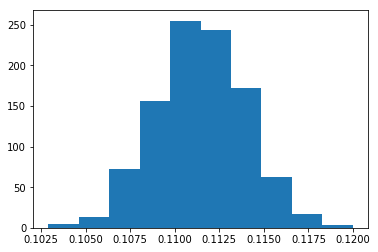

In [13]:
plt.hist(x=params['Y_'].ravel())